Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     1.212309e+05     4.259177e+11
 * time: 0.0
     1     1.212309e+05     3.926767e+11
 * time: 0.0
     2     1.212309e+05     3.499271e+11
 * time: 0.0
     3     1.212309e+05     2.935435e+11
 * time: 0.0
     4     1.212309e+05     2.129588e+11
 * time: 0.0
     5     1.212309e+05     3.457600e+04
 * time: 0.00800013542175293
     6     1.212309e+05     3.141021e+04
 * time: 0.00800013542175293
     7     1.212309e+05     2.934364e+04
 * time: 0.00800013542175293
     8     1.212309e+05     2.733348e+04
 * time: 0.00800013542175293
     9     1.212309e+05     2.602833e+04
 * time: 0.00800013542175293
    10     1.212309e+05     2.599071e+04
 * time: 0.00800013542175293
    11     1.175804e+05     2.486022e+04
 * time: 0.00800013542175293
    12     1.175804e+05     2.372379e+04
 * time: 0.00800013542175293
    13     1.175804e+05     2.249265e+04
 * time: 0.00800013542175293
    14     1.17

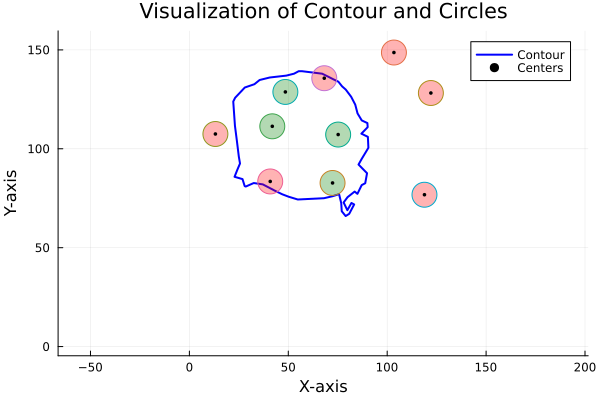

74.43646064304465126.79680565338093
57.286950727854816104.97129404198714
62.672247263834386116.99872487066708
88.80702052074481110.0734226672888
50.09043601770298125.28512442163068
43.7492360516720495.72738751496297
64.3454333370503492.60432025608347
71.71868370364034107.8497861349558
26.31435601910709104.96084696931717
78.3887815416854694.07037208209145


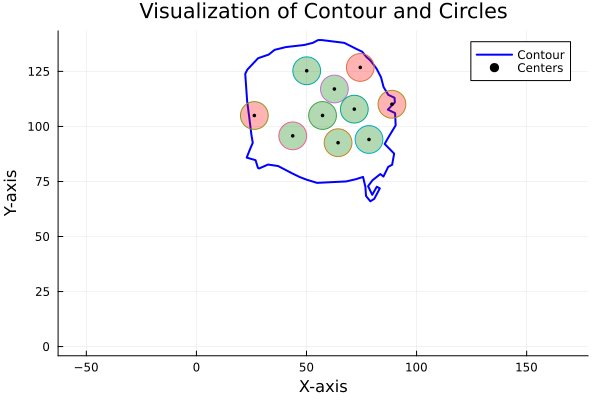

In [22]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics

# Define a Circle struct
struct Circle
    x_coord::Float64
    y_coord::Float64
    radius::Float64
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=0.5)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min
    
    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio
    
    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground
function make_circles(num_circles; radius=6.3, x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position
    
    for i in 1:num_circles
        attempts = 0
        while attempts < max_attempts
            x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
            y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
            overlap = false
            
            # Check if this circle overlaps with any existing circles
            for circle in circles
                if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                    overlap = true
                    break
                end
            end
            
            if !overlap
                # Store the circle with its properties
                push!(circles, Circle(x, y, radius, i))
                break
            end
            
            attempts += 1
        end
        
        # If no non-overlapping position found after max attempts, skip this circle
        if attempts == max_attempts
            println("Failed to place circle $i after $max_attempts attempts")
        end
    end
    
    return circles  # Return an array of circles
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    # Compute the energy between circles
    circle_energy = 0.0

    repulsion_penalty = 1e12

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) -(circle1.radius + circle2.radius)
            if distance > 0
                # energy
                circle_energy += distance^2
            else 
                circle_energy += repulsion_penalty
            end
        end
    end

    
     # Compute contour energy: circles are pulled toward the center and repelled from contour boundary
    contour_energy = 0.0
    repulsion_strength = 1e12  # Strength of repulsion from the contour
    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for circle in circles
         # 1. Attraction to the center of the contour
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        contour_energy += distance_to_center^2  # Attraction force to the center
 
         # 2. Repulsion from the contour boundary
        for (px, py) in zip(smooth_x, smooth_y)
            distance_to_boundary = sqrt((px - circle.x_coord)^2 + (py - circle.y_coord)^2) - circle.radius
            if distance_to_boundary < 0  # Circle is touching or outside the boundary
                #contour_energy += distance_to_boundary * repulsion_strength  # Strong repulsion if touching
            elseif distance_to_boundary < circle.radius
                #contour_energy += (circle.radius - distance_to_boundary) * repulsion_strength  # Soft repulsion if too close
            end
        end
    end

    # Total energy
    total_energy = circle_energy + contour_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        # Check if the circle is completely inside the contour
        if circle_in_polygon(circle, smooth_x, smooth_y)
            # Plot circle inside with green color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
            println(circle.x_coord, circle.y_coord)           
        else
            # Plot circle outside with red color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
            println(circle.x_coord, circle.y_coord)           
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end


# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]


# Generate fine splines and interpolated points for the contour
smooth_x, smooth_y = create_fine_spline(x, y)

# Determine the playground dimensions
x_min, x_max, y_min, y_max = make_playground(x, y)

num_circles = 10
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

function optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
    function objective(params)
        num_circles = length(circles)
        updated_circles = [Circle(params[2*i-1], params[2*i], circles[i].radius, circles[i].label) for i in 1:num_circles]
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    # Flatten x and y coordinates into the initial_params array
    initial_params = [i % 2 == 1 ? circles[(i+1) ÷ 2].x_coord : circles[i ÷ 2].y_coord for i in 1:(2*length(circles))]

    # Set up the optimization with termination on insufficient decrease and max iterations
    options = Optim.Options(
        show_trace = true,   # Show trace of optimization steps
        #f_tol = 1e-8,        # Terminate when the improvement in the function value is less than this tolerance
        #g_tol = 1e-6,        # Gradient tolerance
        iterations = 1000   # Maximum number of iterations (stops when t = 10)
    )

    # Perform the optimization using NelderMead with the defined options
    result = optimize(objective, initial_params, NelderMead(), options)
    optimized_params = Optim.minimizer(result)

    # Create a new list of updated circles using the optimized x and y coordinates
    updated_circles = [Circle(optimized_params[2*i-1], optimized_params[2*i], circles[i].radius, circles[i].label) for i in 1:length(circles)]
    
    return updated_circles
end

# Example call to optimization
optimized_circles = optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
visualize_contour_and_circles(smooth_x, smooth_y, circles)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)



In [23]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics

# Define a Circle struct
struct Circle
    x_coord::Float64
    y_coord::Float64
    radius::Float64
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=0.25)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min
    
    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio
    
    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground
function make_circles(num_circles; radius=6.3, x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position
    
    for i in 1:num_circles
        attempts = 0
        while attempts < max_attempts
            x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
            y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
            overlap = false
            
            # Check if this circle overlaps with any existing circles
            for circle in circles
                if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                    overlap = true
                    break
                end
            end
            
            if !overlap
                # Store the circle with its properties
                push!(circles, Circle(x, y, radius, i))
                break
            end
            
            attempts += 1
        end
        
        # If no non-overlapping position found after max attempts, skip this circle
        if attempts == max_attempts
            println("Failed to place circle $i after $max_attempts attempts")
        end
    end
    
    return circles  # Return an array of circles
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    # Compute the energy between circles
    circle_energy = 0.0

    repulsion_penalty = 1e12

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) - (circle1.radius + circle2.radius)
            
               
            circle_energy += distance^2
            
        end
    end

    
     # Compute contour energy: circles are pulled toward the center and repelled from contour boundary
    center_energy = 0.0
    repell_energy = 0.0

    repulsion_strength = 1e6  # Strength of repulsion from the contour
    
    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for circle in circles
         # 1. Attraction to the center of the contour
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        center_energy += distance_to_center^2  # Attraction force to the center
 
         # 2. Repulsion from the contour boundary
        for (px, py) in zip(smooth_x, smooth_y)
            distance_to_boundary = sqrt((px - circle.x_coord)^2 + (py - circle.y_coord)^2) - circle.radius
            if circle_in_polygon(circle, circle.x_coord, circle.y_coord) # Circle is touching or outside the boundary
                #repell_energy += 1 / distance_to_boundary * repulsion_strength  
            end
        end
    end

    # Total energy
    total_energy = circle_energy + 0*center_energy + 0*repell_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        # Check if the circle is completely inside the contour
        if circle_in_polygon(circle, smooth_x, smooth_y)
            # Plot circle inside with green color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
            #println(circle.x_coord, circle.y_coord)           
        else
            # Plot circle outside with red color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
            #println(circle.x_coord, circle.y_coord)           
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end


# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]


# Generate fine splines and interpolated points for the contour
smooth_x, smooth_y = create_fine_spline(x, y)

# Determine the playground dimensions
x_min, x_max, y_min, y_max = make_playground(x, y)

num_circles = 4
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

function optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
    function objective(params)
        num_circles = length(circles)
        updated_circles = [Circle(params[2*i-1], params[2*i], circles[i].radius, circles[i].label) for i in 1:num_circles]
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    # Flatten x and y coordinates into the initial_params array
    initial_params = [i % 2 == 1 ? circles[(i+1) ÷ 2].x_coord : circles[i ÷ 2].y_coord for i in 1:(2*length(circles)) : #radius]

    # Set up the optimization with termination on insufficient decrease and max iterations
    options = Optim.Options(
        show_trace = true,   # Show trace of optimization steps
        show_every = 10,
        f_tol = 1e-8,        # Terminate when the improvement in the function value is less than this tolerance
        g_tol = 1e-6,        # Gradient tolerance
        iterations = 10000   # Maximum number of iterations (stops when t = 10)
    )

    # Perform the optimization using NelderMead with the defined options
    result = optimize(objective, initial_params, NelderMead(), options)
    optimized_params = Optim.minimizer(result)

    # Create a new list of updated circles using the optimized x and y coordinates
    updated_circles = [Circle(optimized_params[2*i-1], optimized_params[2*i], circles[i].radius, circles[i].label) for i in 1:length(circles)]
    
    return updated_circles
end

# Example call to optimization
optimized_circles = optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
visualize_contour_and_circles(smooth_x, smooth_y, circles)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)



LoadError: ParseError:
[90m# Error @ [0;0m]8;;file://c:/Users/mouli/OneDrive/Documents/Math512/In[23]#203:13\[90mIn[23]:203:13[0;0m]8;;\
    # Set up the optimization with termination on insufficient decrease and max iterations
[90m#           ┌───────────────[0;0m
    options [48;2;120;70;70m= Optim.Options([0;0m
[48;2;120;70;70m        show_trace = true,   # Show trace of optimization steps[0;0m
[48;2;120;70;70m[0;0m⋮
[48;2;120;70;70m        g_tol = 1e-6,        # Gradient tolerance[0;0m
[48;2;120;70;70m        iterations = 10000[0;0m   # Maximum number of iterations (stops when t = 10)
[90m#────────────────────────┘ ── [0;0m[91mExpected `]`[0;0m

In [ ]:
using LinearAlgebra, DelaunayTriangulation, Random, Optim, Plots, Dierckx

# Define allowed radii
const allowed_radii = [6.3, 4.9, 2.8, 1.4]

# Define Circle struct for individual circles
struct Circle
    x_coord::Float64
    y_coord::Float64
    radius::Float64
    label::Int
end

# Helper function: Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) && (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Helper function: Check if a circle is fully within the polygon
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)
    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Helper function: Create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Helper function: Determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=0.5)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio
    return x_min, x_max, y_min, y_max
end

# Function to create circles within the playground with initial largest radius
function make_circles(num_circles; x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    for i in 1:num_circles
        x = rand() * (x_max - x_min) + x_min
        y = rand() * (y_max - y_min) + y_min
        push!(circles, Circle(x, y, allowed_radii[1], i))  # Start with the largest radius
    end
    return circles
end

# Helper function: Distance from point to line segment
function point_to_line_segment_distance(px, py, x1, y1, x2, y2)
    dx, dy = x2 - x1, y2 - y1
    if (dx == 0) && (dy == 0)
        return sqrt((px - x1)^2 + (py - y1)^2)
    end
    t = clamp(((px - x1) * dx + (py - y1) * dy) / (dx^2 + dy^2), 0.0, 1.0)
    closest_x, closest_y = x1 + t * dx, y1 + t * dy
    return sqrt((px - closest_x)^2 + (py - closest_y)^2)
end

# Function to find the shortest distance from a circle to the nearest edge of a polygon
function distance_to_nearest_edge(circle::Circle, polygon_x, polygon_y)
    nearest_distance = Inf
    num_points = length(polygon_x)
    for i in 1:num_points
        x1, y1 = polygon_x[i], polygon_y[i]
        x2, y2 = polygon_x[mod1(i + 1, num_points)]
        distance = point_to_line_segment_distance(circle.x_coord, circle.y_coord, x1, y1, x2, y2)
        nearest_distance = min(nearest_distance, distance)
    end
    return nearest_distance
end

# Create a Delaunay triangulation-based binary connectivity matrix
function create_delaunay_connectivity(circles)
    points = [(circle.x_coord, circle.y_coord) for circle in circles]
    tri = triangulate(points)
    connectivity = Dict(i => Int[] for i in 1:length(circles))
    for triangle in tri.triangles
        for (i, j) in [(triangle[1], triangle[2]), (triangle[2], triangle[3]), (triangle[3], triangle[1])]
            if j ∉ connectivity[i]
                push!(connectivity[i], j)
            end
            if i ∉ connectivity[j]
                push!(connectivity[j], i)
            end
        end
    end
    return connectivity
end

# Convert Delaunay connectivity to binary matrix
function create_binary_connectivity_matrix(circles)
    connectivity = create_delaunay_connectivity(circles)
    N = length(circles)
    binary_matrix = zeros(Int, N, N)
    for (i, neighbors) in connectivity
        for j in neighbors
            binary_matrix[i, j] = 1
            binary_matrix[j, i] = 1
        end
    end
    return binary_matrix
end

# Compute system energy using Lennard-Jones potential and boundary repulsion
function compute_system_energy(circles, smooth_x, smooth_y)
    circle_energy, center_energy, repell_energy = 0.0, 0.0, 0.0
    contour_center_x, contour_center_y = mean(smooth_x), mean(smooth_y)
    binary_matrix = create_binary_connectivity_matrix(circles)

    for i in 1:length(circles)
        for j in i+1:length(circles)
            if binary_matrix[i, j] == 1
                distance = sqrt((circles[i].x_coord - circles[j].x_coord)^2 + (circles[i].y_coord - circles[j].y_coord)^2) - (circles[i].radius + circles[j].radius)
                if distance < 0
                    circle_energy += 1e12
                else
                    circle_energy += 4 * ((1 / distance)^12 - (1 / distance)^6)
                end
            end
        end
        distance_to_center = sqrt((circles[i].x_coord - contour_center_x)^2 + (circles[i].y_coord - contour_center_y)^2)
        center_energy += distance_to_center^2
        shortest_distance = distance_to_nearest_edge(circles[i], smooth_x, smooth_y)
        if shortest_distance > 0
            repell_energy += 1 / shortest_distance * 1e6
        else
            repell_energy += 1e12
        end
    end
    total_energy = circle_energy + center_energy + repell_energy
    return isnan(total_energy) ? Inf : total_energy
end

# Function to visualize the circles and contour
function visualize_contour_and_circles(smooth_x, smooth_y, circles; title="Circle Arrangement")
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        plot!(plt,
              [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
              [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
              label=false, fill=(0, :green, 0.3))
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(plt, xlabel="X-axis", ylabel="Y-axis", title=title)
    display(plt)
end

# Optimization function for circles
function optimize_circles(circles, smooth_x, smooth_y)
    function objective(params::Vector{Float64})
        updated_circles = [Circle(circles[i].x_coord, circles[i].y_coord, allowed_radii[clamp(Int(params[i]), 1, length(allowed_radii))], circles[i].label) for i in 1:length(circles)]
        energy = compute_system_energy(updated_circles, smooth_x, smooth_y)
        return isnan(energy) ? Inf : energy
    end
    initial_params = rand(1:4, length(circles))
    options = Optim.Options(show_trace=true, iterations=500)
    result = optimize(objective, initial_params, SimulatedAnnealing(), options)
    optimized_params = Optim.minimizer(result)
    updated_circles = [Circle(circles[i].x_coord, circles[i].y_coord, allowed_radii[clamp(Int(optimized_params[i]), 1, length(allowed_radii))], circles[i].label) for i in 1:length(circles)]
    return updated_circles
end

# Example setup and visualization
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]

smooth_x, smooth_y = create_fine_spline(x, y)
x_min, x_max, y_min, y_max = make_playground(x, y)
num_circles = 8
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

println("Initial System Energy: $(compute_system_energy(circles, smooth_x, smooth_y))")
visualize_contour_and_circles(smooth_x, smooth_y, circles, title="Before Optimization")

optimized_circles = optimize_circles(circles, smooth_x, smooth_y)

println("Optimized System Energy: $(compute_system_energy(optimized_circles, smooth_x, smooth_y))")
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles, title="After Optimization")